<a href="https://colab.research.google.com/github/gregoriussitindaon/ecommerce-customer-revenue-retention-analysis/blob/main/notebooks/01_eda_rfm_retention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Revenue & Retention Analysis (E-Commerce)

Analisis ini bertujuan untuk memahami bagaimana pola transaksi pelanggan berkontribusi terhadap pendapatan perusahaan e-commerce, serta mengidentifikasi segmen pelanggan yang paling bernilai untuk strategi retensi.

Fokus utama:
- Mengukur distribusi pendapatan per pelanggan.
- Menyusun segmentasi pelanggan berbasis RFM (Recency, Frequency, Monetary).
- Memberi rekomendasi taktis berbasis data untuk mendukung keputusan bisnis.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

pd.set_option('display.max_columns', 100)
plt.style.use('default')
sns.set()

**1. LOAD DATA**

In [2]:
import pandas as pd

base_path = '/content/drive/MyDrive/data_olist/'  # sesuaikan dengan nama foldermu

orders = pd.read_csv(base_path + 'olist_orders_dataset.csv')
order_items = pd.read_csv(base_path + 'olist_order_items_dataset.csv')
payments = pd.read_csv(base_path + 'olist_order_payments_dataset.csv')
customers = pd.read_csv(base_path + 'olist_customers_dataset.csv')
products = pd.read_csv(base_path + 'olist_products_dataset.csv')

## Data Overview & Business Assumptions

Dataset yang digunakan merepresentasikan transaksi e-commerce multi-seller, dengan beberapa tabel utama:
- **orders**: informasi pesanan dan status pengiriman,
- **order_items**: detail produk per pesanan,
- **payments**: nilai pembayaran,
- **customers**: identitas unik pelanggan,
- **products**: kategori produk.

Agar analisis lebih relevan dengan pendapatan aktual, beberapa keputusan dibuat:
1. Hanya pesanan dengan status `delivered` yang dihitung sebagai _revenue_.
2. Nilai pendapatan dihitung dari kombinasi harga produk dan biaya pengiriman yang dibayar pelanggan.
3. Analisis difokuskan pada level **customer_unique_id** untuk menangkap perilaku pelanggan, bukan hanya jumlah order.

Pendekatan ini meniru praktik analitik di perusahaan, di mana kualitas data dan definisi metrik harus ditentukan secara eksplisit sebelum interpretasi bisnis dilakukan.

**2. CEK STRUKTUR DASAR & KUALITAS DATA**

In [4]:
print("Orders:", orders.shape)
print("Order items:", order_items.shape)
print("Payments:", payments.shape)
print("Customers:", customers.shape)
print("Products:", products.shape)

orders.head()

Orders: (99441, 8)
Order items: (112650, 7)
Payments: (103886, 5)
Customers: (99441, 5)
Products: (32951, 9)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Ada missing di beberapa kolom tanggal, tapi tidak kritikal untuk analisis revenue dasar.

In [5]:
orders['order_status'].value_counts(normalize=True)

,proportion
order_status,
delivered,0.970203
shipped,0.011132
canceled,0.006285
unavailable,0.006124
invoiced,0.003158
processing,0.003027
created,0.000050
approved,0.000020


In [6]:
orders.isna().mean().sort_values(ascending=False).head(10)

,0
order_delivered_customer_date,0.029817
order_delivered_carrier_date,0.017930
order_approved_at,0.001609
order_id,0.000000
order_purchase_timestamp,0.000000
order_status,0.000000
customer_id,0.000000
order_estimated_delivery_date,0.000000


Kita hanya akan pakai delivered sebagai transaksi valid.

**3. FILTER ORDER VALID & GABUNGKAN TABEL**

In [7]:
# Gunakan hanya pesanan yang benar-benar terkirim
valid_orders = orders[orders['order_status'] == 'delivered'].copy()

# Merge order_items + payments
order_items_pay = pd.merge(
    order_items,
    payments.groupby('order_id', as_index=False)['payment_value'].sum(),
    on='order_id',
    how='left'
)

# Gabung dengan orders
order_full = pd.merge(
    valid_orders,
    order_items_pay,
    on='order_id',
    how='left'
)

# Gabung dengan customers
order_full = pd.merge(
    order_full,
    customers[['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']],
    on='customer_id',
    how='left'
)

# Gabung dengan products (opsional, untuk analisis kategori)
order_full = pd.merge(
    order_full,
    products[['product_id', 'product_category_name']],
    on='product_id',
    how='left'
)

order_full.shape, order_full.head()


((110197, 19),
                            order_id                       customer_id  \
 0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
 1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
 2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
 3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
 4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
 
   order_status order_purchase_timestamp    order_approved_at  \
 0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
 1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
 2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
 3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
 4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
 
   order_delivered_carrier_date order_delivered_customer_date  \
 0          2017-10-04 19:55:00           2017-10-10 21:25:13   
 1          2018-

**4. HITUNG REVENUE per ORDER**

In [8]:
order_full['item_revenue'] = order_full['price'] + order_full['freight_value']

order_rev = (order_full
             .groupby(['order_id', 'customer_unique_id'], as_index=False)
             .agg(
                 order_purchase_timestamp=('order_purchase_timestamp', 'max'),
                 revenue=('item_revenue', 'sum')
             ))

order_rev.head()

,order_id,customer_unique_id,order_purchase_timestamp,revenue
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,72.19
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,259.83
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,216.87
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,218.04


CEK DISTRIBUSI REVENUE per ORDER

In [9]:
order_rev['revenue'].describe(percentiles=[0.5, 0.9, 0.99])

,revenue
count,96478.000000
mean,159.826839
std,218.794219
min,9.590000
50%,105.280000
90%,305.918000
99%,1052.389900
max,13664.080000


**5. BANGUN CUSTOMER-LEVEL DATASET**

In [10]:
customer_rev = (order_rev
                .groupby('customer_unique_id', as_index=False)
                .agg(
                    first_purchase=('order_purchase_timestamp', 'min'),
                    last_purchase=('order_purchase_timestamp', 'max'),
                    frequency=('order_id', 'nunique'),
                    monetary=('revenue', 'sum')
                ))

customer_rev['first_purchase'] = pd.to_datetime(customer_rev['first_purchase'])
customer_rev['last_purchase'] = pd.to_datetime(customer_rev['last_purchase'])

customer_rev.head()

,customer_unique_id,first_purchase,last_purchase,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1,27.19
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1,196.89


## RFM Methodology

Untuk memprofilkan nilai pelanggan, digunakan pendekatan **RFM (Recency, Frequency, Monetary)**:

- **Recency**: jumlah hari sejak transaksi terakhir sampai _snapshot date_. Semakin kecil → semakin baru/aktif.
- **Frequency**: jumlah pesanan yang dilakukan pelanggan. Semakin sering → semakin engaged.
- **Monetary**: total nilai transaksi pelanggan. Semakin besar → semakin bernilai secara finansial.

Skor R, F, dan M dibentuk menggunakan kuartil:
- Pelanggan dengan performa lebih baik pada masing-masing dimensi mendapat skor lebih tinggi.
- Skor digabungkan menjadi `rfm_score` untuk memetakan pelanggan ke beberapa segmen prioritas.

**6. HITUNG RECENCY & TABEL RFM**

In [11]:
snapshot_date = customer_rev['last_purchase'].max() + pd.Timedelta(days=1)

customer_rev['recency'] = (snapshot_date - customer_rev['last_purchase']).dt.days

rfm = customer_rev[['customer_unique_id', 'recency', 'frequency', 'monetary']].copy()

rfm.describe()

,recency,frequency,monetary
count,93358.000000,93358.000000,93358.000000
mean,237.941773,1.033420,165.168210
std,152.591453,0.209097,226.292101
min,1.000000,1.000000,9.590000
25%,114.000000,1.000000,63.010000
50%,219.000000,1.000000,107.780000
75%,346.000000,1.000000,182.510000
max,714.000000,15.000000,13664.080000


**7. SKORING RFM dengan KUARTIL**

In [12]:
# Recency: makin kecil makin bagus → skor tinggi
rfm['r_score'] = pd.qcut(rfm['recency'], 4, labels=[4,3,2,1]).astype(int)

# Frequency & Monetary: makin besar makin bagus
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['m_score'] = pd.qcut(rfm['monetary'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)

rfm['rfm_score'] = rfm['r_score'] + rfm['f_score'] + rfm['m_score']

rfm.head()

,customer_unique_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,3,8
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,5
2,0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,4
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,4
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,4,7


**8. SEGMENTASI PELANGGAN**

In [13]:
def assign_segment(row):
    score = row['rfm_score']
    if score >= 10:
        return 'Champion'
    elif score >= 8:
        return 'Loyal'
    elif score >= 6:
        return 'Potential Loyalist'
    else:
        return 'At Risk / Low Value'

rfm['segment'] = rfm.apply(assign_segment, axis=1)

rfm['segment'].value_counts(normalize=True).sort_values(ascending=False)


,proportion
segment,
Potential Loyalist,0.342145
Loyal,0.333148
Champion,0.163328
At Risk / Low Value,0.161379


## Customer Segmentation Logic

Segmentasi sederhana digunakan untuk mengelompokkan pelanggan:

- **Champion**: skor RFM tertinggi. Pelanggan sangat aktif dan berkontribusi besar terhadap revenue.
- **Loyal**: pembeli berulang dengan nilai transaksi yang konsisten.
- **Potential Loyalist**: pelanggan dengan potensi menjadi loyal jika dikelola dengan tepat.
- **At Risk / Low Value**: pelanggan dengan frekuensi rendah, nilai kecil, atau sudah lama tidak bertransaksi.

Segmentasi ini bukan hanya klasifikasi teknis, tetapi fondasi untuk strategi:
- program loyalitas,
- prioritas layanan,
- campaign retensi yang lebih terarah.

**9. ANALISIS KONTRIBUSI REVENUE per SEGMEN**

In [14]:
segment_rev = (rfm
               .groupby('segment', as_index=False)['monetary']
               .sum()
               .sort_values('monetary', ascending=False))

segment_rev

,segment,monetary
2,Loyal,5998234.21
1,Champion,4452126.51
3,Potential Loyalist,3991978.32
0,At Risk / Low Value,977434.71


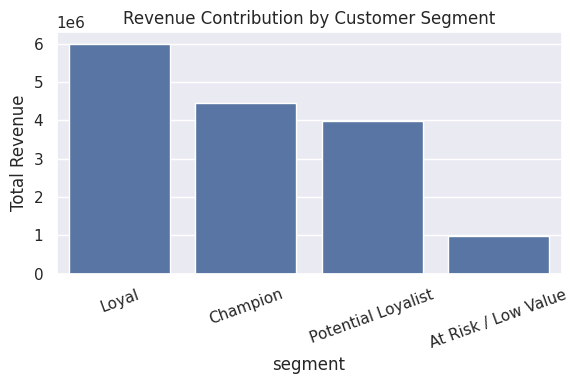

In [15]:
plt.figure(figsize=(6,4))
sns.barplot(data=segment_rev, x='segment', y='monetary')
plt.title('Revenue Contribution by Customer Segment')
plt.ylabel('Total Revenue')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

## Key Insights (Illustrative)

Beberapa pola utama dari hasil analisis (contoh, sesuaikan dengan output aktual):

1. **Konsentrasi Pendapatan**
   - Sebagian besar pendapatan terkonsentrasi pada segmen *Champion* dan *Loyal Customers*.
   - Implikasi: kehilangan sebagian kecil pelanggan di segmen ini akan berdampak signifikan pada pendapatan total.

2. **Dominasi Single-Purchase Customers**
   - Proporsi pelanggan dengan hanya satu transaksi cukup besar.
   - Hal ini menunjukkan bahwa proses akuisisi berjalan, tetapi mekanisme retensi belum optimal.

3. **Peluang Retensi**
   - Segmen *Potential Loyalist* memiliki frekuensi dan nilai transaksi menengah.
   - Dengan intervensi yang tepat (personalized offer, free shipping, priority support), segmen ini berpotensi naik menjadi *Loyal* atau *Champion*.

4. **Distribusi Nilai Transaksi**
   - Distribusi monetary menunjukkan ekor panjang (sedikit pelanggan dengan nilai transaksi sangat tinggi).
   - Pelanggan ini layak mendapatkan program VIP atau layanan premium untuk menjaga loyalitas mereka.

Insight ini relevan secara bisnis karena langsung terkait dengan strategi:
- pengalokasian budget marketing,
- desain program loyalitas,
- prioritas peningkatan kualitas layanan.

**10. DISTRIBUSI FREQUENCY & MONETARY**

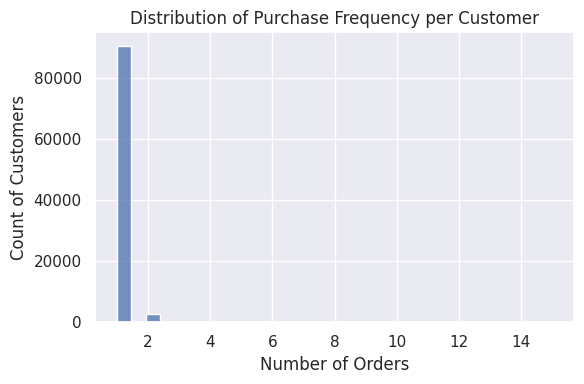

In [16]:
plt.figure(figsize=(6,4))
sns.histplot(rfm['frequency'], bins=30)
plt.title('Distribution of Purchase Frequency per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Count of Customers')
plt.tight_layout()
plt.show()

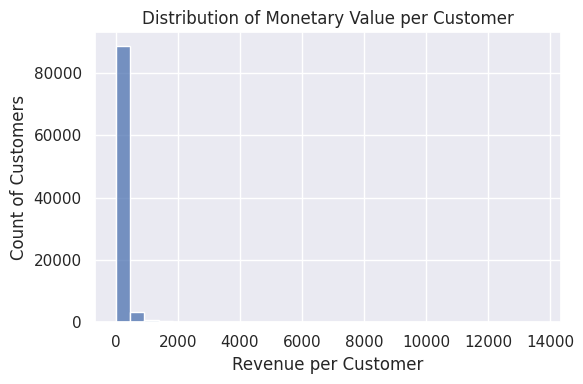

In [17]:
plt.figure(figsize=(6,4))
sns.histplot(rfm['monetary'], bins=30)
plt.title('Distribution of Monetary Value per Customer')
plt.xlabel('Revenue per Customer')
plt.ylabel('Count of Customers')
plt.tight_layout()
plt.show()

## Business Recommendations

Berdasarkan analisis RFM dan pola transaksi pelanggan, beberapa rekomendasi strategis yang dapat dipertimbangkan:

1. **Prioritaskan Segmen High-Value**
   Fokuskan program loyalitas, layanan cepat, dan komunikasi personal pada segmen *Champion* dan *Loyal*, karena mereka menyumbang porsi pendapatan terbesar.

2. **Aktifkan Program Retensi Dini**
   Rancang campaign otomatis untuk pelanggan baru dalam 30–60 hari pertama
   (contoh: diskon repeat order, bundling produk, reminder keranjang).

3. **Optimalkan Biaya Akuisisi**
   Jika proporsi pelanggan sekali beli sangat tinggi, evaluasi strategi akuisisi:
   - apakah channel marketing mendatangkan pelanggan yang berkualitas,
   - atau hanya menghasilkan _one-time buyer_ yang tidak berkontribusi jangka panjang.

4. **Gunakan Segmentasi untuk Personalisasi**
   Terapkan messaging yang berbeda per segmen:
   - *Champion*: eksklusivitas dan early access.
   - *Potential Loyalist*: insentif untuk repeat.
   - *At Risk*: win-back campaign dengan penawaran khusus.

Analisis ini menunjukkan bagaimana Python dan data transaksi dapat diterjemahkan menjadi keputusan bisnis yang terukur, bukan sekadar visualisasi deskriptif.